<a href="https://colab.research.google.com/github/YuHsin-Chen1221/Medical-Diagnosis-Models/blob/main/Brain_Tumor_Segmentation_with_MONAI_U-Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
!pip install monai torch matplotlib

In [10]:
!pip install monai[itk]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 53.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.5/28.5 MB 53.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 82.1 MB/s eta 0:00:00


In [2]:
!pip install kaggle

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/Kaggle_API/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [34]:
!kaggle datasets download -d nikhilroxtomar/brain-tumor-segmentation

Dataset URL: https://www.kaggle.com/datasets/nikhilroxtomar/brain-tumor-segmentation
License(s): unknown
brain-tumor-segmentation.zip: Skipping, found more recently modified local copy (use --force to force download)


In [35]:
!unzip /content/brain-tumor-segmentation.zip

Archive:  /content/brain-tumor-segmentation.zip
replace images/1.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [36]:
# build datalist

import os
from glob import glob

image_dir = '/content/images'
mask_dir = '/content/masks'
image_files = sorted(glob(os.path.join(image_dir, '*.png')))
mask_files = sorted(glob(os.path.join(mask_dir, '*.png')))

image_files = image_files[:500]
mask_files = mask_files[:500]

datalist = [
    {'image': img_path, 'label': mask_path}
    for img_path, mask_path in zip(image_files, mask_files)
]

In [48]:
# data augmentation & transformation

import monai
from monai.data import Dataset, CacheDataset
from monai.transforms import (
    Compose,
    LoadImaged,
    EnsureChannelFirstd,
    ScaleIntensityRanged,
    Resized,
    Lambdad,
    Rotated,
    AsDiscrete # Keep import for potential later use or illustration
)
import numpy as np

transform = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    Lambdad(keys=["image", "label"], func=lambda x: x.astype("float32")),  # Ensure correct type
    ScaleIntensityRanged(keys=["image"], a_min=0, a_max=255, b_min=0.0, b_max=1.0),
    Resized(keys=["image", "label"], spatial_size=(256, 256)),
    Rotated(keys=["image", "label"], angle=15, keep_size=True),
    # Removed: AsDiscrete(keys=["label"], to_onehot=2), # Perform one-hot encoding in the training loop instead
])

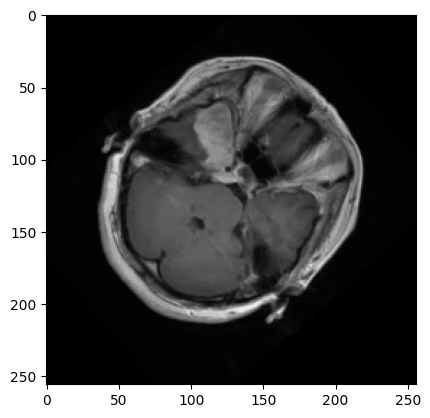

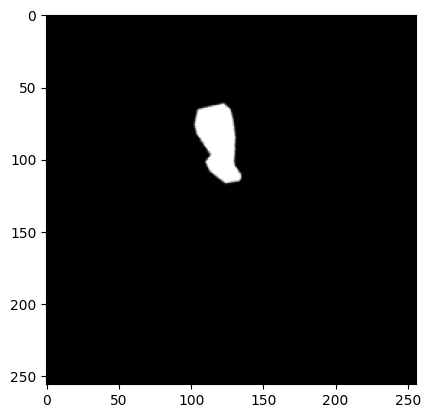

In [27]:
import matplotlib.pyplot as plt

sample = datalist[0]
transformed = transform(sample)
def imshow(x, title=None):
    plt.figure()
    plt.imshow(x[0], cmap='gray')
    plt.show()

imshow(transformed['image'])
imshow(transformed['label'])

In [49]:
# comparing dataloaders

from tqdm import tqdm
from monai.data import DataLoader

ds = Dataset(data=datalist, transform=transform)
loader_ds = DataLoader(ds, batch_size=4, shuffle=True)

cached_ds = CacheDataset(data=datalist, transform=transform, cache_rate=1.0, num_workers=4)
loader_cached = DataLoader(cached_ds, batch_size=4, shuffle=True)

import time
from tqdm import tqdm

def measure_dataloader_speed(dataloader, description=""):
    start = time.time()
    for _ in tqdm(dataloader, desc=description):
        pass  # simulate usage (e.g., model training step)
    end = time.time()
    return end - start
time_ds = measure_dataloader_speed(loader_ds, description="Standard")
time_cached = measure_dataloader_speed(loader_cached, description="Cached")


Cached: 100%|██████████| 125/125 [00:00<00:00, 1310.00it/s]


In [50]:
# data splitting

from sklearn.model_selection import train_test_split
train_data, val_data = train_test_split(datalist, test_size=0.2, random_state=42)

train_ds = Dataset(data=train_data, transform=transform)
val_ds = Dataset(data=val_data, transform=transform)


In [51]:
# prep data loaders for training & validating data

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=4, shuffle=False, num_workers=2)


In [57]:
# U-Net model building with MONAI elements

import torch
from monai.networks.nets import UNet
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.inferers import sliding_window_inference
from monai.transforms import Compose, EnsureType

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet(
    spatial_dims=2,             # 2D spatial dimensions
    in_channels=1,              # Number of input channels (e.g., grayscale image = 1)
    out_channels=2,             # Number of output classes (background + object)
    channels=(16, 32, 64, 128, 256),  # Feature map sizes at each layer
    strides=(2, 2, 2, 2),       # Downsampling stride at each level
    num_res_units=2,            # Number of residual units per stage
).to(device)

loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [69]:
from monai.metrics import DiceMetric
from monai.transforms import AsDiscrete
import torch # Import torch

# Metric tools
post_pred = AsDiscrete(argmax=True, to_onehot=2)  # prediction post-processing
post_label = AsDiscrete(to_onehot=2)              # label post-processing
dice_metric = DiceMetric(include_background=False, reduction="mean")

epochs = 30
train_losses = []
train_accuracies = []
dice_scores = []

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")
    model.train()
    epoch_loss = 0
    total_correct = 0
    total_pixels = 0
    step = 0

    for batch_data in train_loader:
        inputs = batch_data["image"].to(device)
        labels = batch_data["label"].to(device)

        # Ensure labels are strictly 0 or 1 and long type
        labels = torch.clamp(labels, 0, 1).long() # Clamp values and convert to long

        optimizer.zero_grad()

        outputs = model(inputs)  # Shape: [B, 2, H, W]
        # Pass labels with channel dimension to loss_function
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        # Accuracy calculation
        preds = torch.argmax(outputs, dim=1)  # Shape: [B, H, W]
        # Compare predictions with the original labels (without channel dimension)
        correct = torch.eq(preds, labels.squeeze(1)).sum().item()
        total = torch.numel(labels.squeeze(1))


        total_correct += correct
        total_pixels += total
        epoch_loss += loss.item()
        step += 1

    # Compute Dice and accuracy
    epoch_acc = total_correct / total_pixels
    # mean_dice = dice_metric.aggregate().item() # Commented out this line
    # dice_metric.reset() # Commented out this line

    train_losses.append(epoch_loss / step)
    train_accuracies.append(epoch_acc)
    # dice_scores.append(mean_dice) # Commented out this line


    # print(f"Avg Loss: {epoch_loss / step:.4f} | Accuracy: {epoch_acc:.4f} | Dice: {mean_dice:.4f}") # Modified print statement
    print(f"Avg Loss: {epoch_loss / step:.4f} | Accuracy: {epoch_acc:.4f}")


Epoch 1/30
Avg Loss: 0.5919 | Accuracy: 0.7972

Epoch 2/30
Avg Loss: 0.5809 | Accuracy: 0.8194

Epoch 3/30
Avg Loss: 0.5713 | Accuracy: 0.8452

Epoch 4/30
Avg Loss: 0.5618 | Accuracy: 0.8914

Epoch 5/30
Avg Loss: 0.5529 | Accuracy: 0.9328

Epoch 6/30
Avg Loss: 0.5439 | Accuracy: 0.9446

Epoch 7/30
Avg Loss: 0.5352 | Accuracy: 0.9574

Epoch 8/30
Avg Loss: 0.5277 | Accuracy: 0.9773

Epoch 9/30
Avg Loss: 0.5176 | Accuracy: 0.9858

Epoch 10/30
Avg Loss: 0.5081 | Accuracy: 0.9880

Epoch 11/30
Avg Loss: 0.4982 | Accuracy: 0.9895

Epoch 12/30
Avg Loss: 0.4879 | Accuracy: 0.9902

Epoch 13/30
Avg Loss: 0.4769 | Accuracy: 0.9917

Epoch 14/30
Avg Loss: 0.4666 | Accuracy: 0.9922

Epoch 15/30
Avg Loss: 0.4560 | Accuracy: 0.9929

Epoch 16/30
Avg Loss: 0.4448 | Accuracy: 0.9936

Epoch 17/30
Avg Loss: 0.4327 | Accuracy: 0.9944

Epoch 18/30
Avg Loss: 0.4190 | Accuracy: 0.9955

Epoch 19/30
Avg Loss: 0.4050 | Accuracy: 0.9959

Epoch 20/30
Avg Loss: 0.3898 | Accuracy: 0.9964

Epoch 21/30
Avg Loss: 0.3744

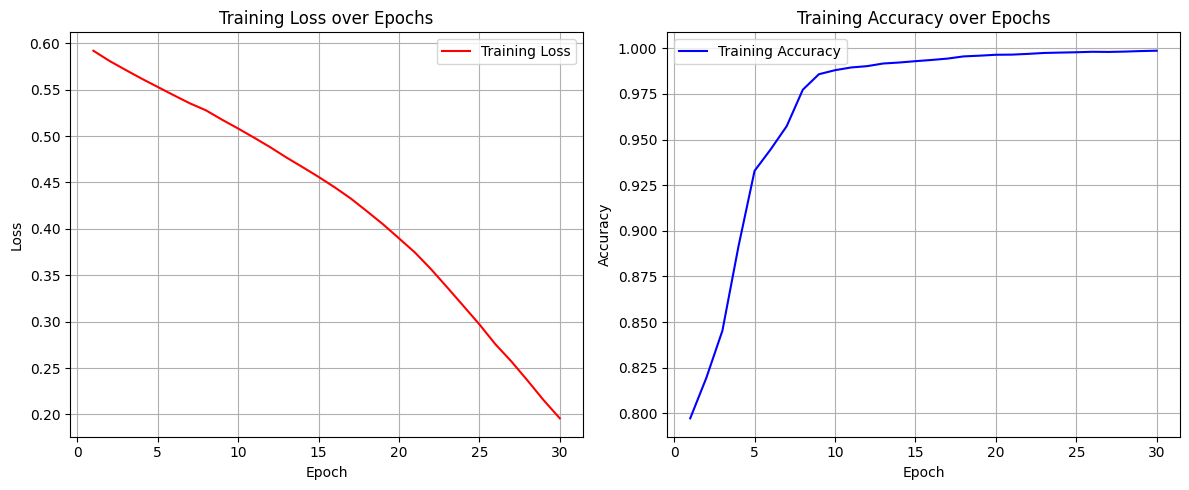

In [71]:
# evaluation & visualization

import matplotlib.pyplot as plt

epochs_range = range(1, epochs + 1)

plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Training Loss', color='red')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.grid(True)
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Training Accuracy', color='blue')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training Accuracy over Epochs")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

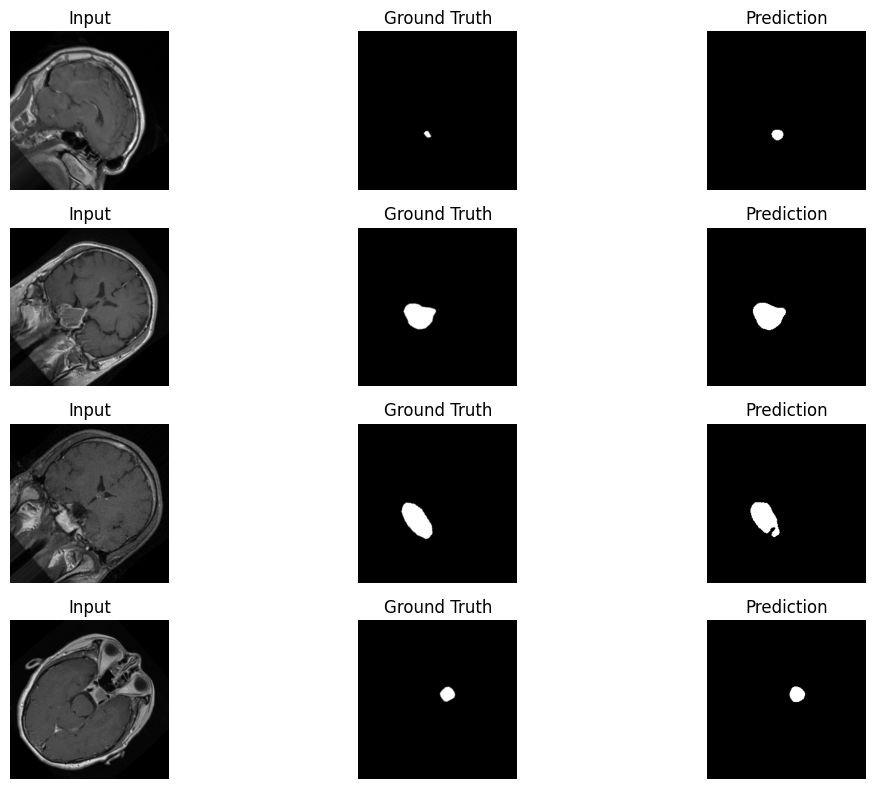

In [72]:
# medical image separation plotting: bg & tumor

model.eval()
with torch.no_grad():
    batch = next(iter(train_loader))
    images = batch["image"].to(device)
    labels = batch["label"].to(device)
    outputs = model(images)
    preds = torch.argmax(outputs, dim=1).cpu().numpy()
    images = images.cpu().numpy()
    labels = labels.cpu().numpy()

# Plot predictions vs. labels
n = 4  # number of samples
plt.figure(figsize=(12, 8))
for i in range(n):
    plt.subplot(n, 3, i*3 + 1)
    plt.imshow(images[i][0], cmap='gray')
    plt.title("Input")
    plt.axis("off")

    plt.subplot(n, 3, i*3 + 2)
    plt.imshow(labels[i][0], cmap='gray')
    plt.title("Ground Truth")
    plt.axis("off")

    plt.subplot(n, 3, i*3 + 3)
    plt.imshow(preds[i], cmap='gray')
    plt.title("Prediction")
    plt.axis("off")

plt.tight_layout()
plt.show()
